# Exploratory Data Analysis of Shoulder Data
Here we aim to expose the main characteristics of a dataset through statistical and visual tools, which can contribute significantly to design a proper solution to the problem of detection and classification of physical activity.

In [30]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime, timedelta
from openmovement.load import CwaData

### Patients' Dictionary - Loading CWA files into a dictionary of datasets
We write the following function to walk through the CWA files, read, re-sample and add into a single data structure.

In [2]:
def load_cwa(filename):
    with CwaData(filename, include_gyro=True, include_temperature=False) as cwa_data:
        samples = cwa_data.get_samples()
        samples = samples.set_index('time')
        samples = samples.astype('float32')
        samples = samples.resample('50ms').sum()
    return samples

In [3]:
def load_data(dir_dataset, pat_file_names):
    """
    Load data and creates a dictionary.

    Parameters:
    dir_dataset: directory of dataset files.

    Returns:
    Dictionary containing all files.

    """
    sensor_ds = {}

    for p in pat_file_names:
        idx = 0
        for cwa_f in os.listdir(os.path.join(dir_dataset, p)):
            idx += 1
            file_name = os.path.join(dir_dataset, p, cwa_f)
            df = load_cwa(file_name)
            base_name = p + '_' + str(idx)
            sensor_ds[base_name] = df
    return sensor_ds

In [4]:
DIR_DATASET = '..'
pat_filenames = ['00_506']#,'01_520']
sensor_ds = load_data(DIR_DATASET,pat_filenames)

In [5]:
sensor_ds['00_506_2']

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
time,,,,,,
2022-05-04 11:27:11.750,0.046387,-0.199707,-3.931641,1.098633,1.586914,1.525879
2022-05-04 11:27:11.800,0.138672,-0.633301,-12.768555,3.051758,4.394531,4.516602
2022-05-04 11:27:11.850,0.137207,-0.589844,-11.792969,3.845215,5.187988,4.455566
2022-05-04 11:27:11.900,0.132812,-0.648438,-12.777344,3.295898,5.371094,4.577637
2022-05-04 11:27:11.950,0.136230,-0.587402,-11.792969,3.417969,4.272461,4.272461
...,...,...,...,...,...,...
2022-05-13 17:03:36.900,8.763184,-0.434570,10.372559,-0.427246,-1.037598,14.038086
2022-05-13 17:03:36.950,8.054688,-0.414062,9.584961,6.042480,27.465820,5.371094
2022-05-13 17:03:37.000,8.003906,-0.380859,9.647949,5.187988,19.165039,-0.854492


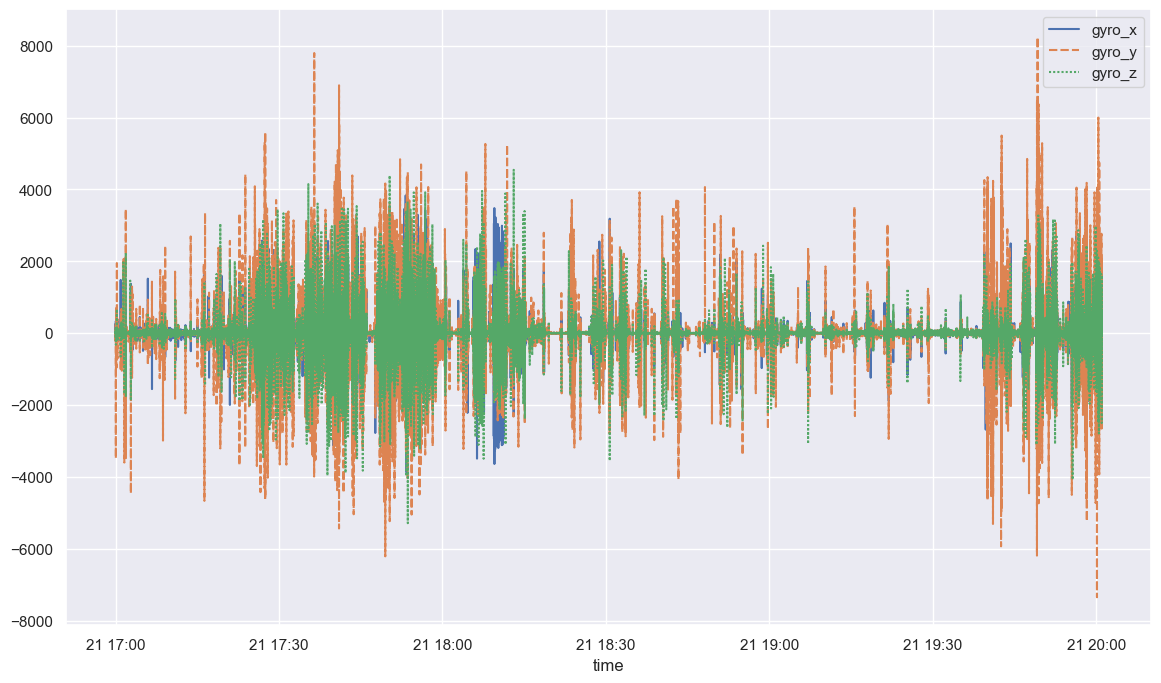

In [59]:
start_time = "2022-05-21 17:00"
end_time = "2022-05-21 20:00"

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=sensor_ds['00_506_1'][start_time:end_time].loc[:,['gyro_x','gyro_y','gyro_z']])
#ax.set_ylim(-0.01,0.01)

### Add labels: Import timestamps of physical activity
In this section we import the Excel file with the timestamps that indicate the beggining of the physical activity at each measurement. In the mean time, we are going to assume that the exercises elapsed 30 minutes. We are going to add a boolean variable to each of the Pandas datasets that indicates whether there is physical activity or not.

In [52]:
def add_timestamps(dict_ds,ts_df):
    for cwa_f in dict_ds:
        dict_ds[cwa_f] = dict_ds[cwa_f].assign(phys=1)
        f_tag = int(cwa_f.split('_')[1])
        aux = ts_df[ts_df["record_id"]==f_tag].iloc[:,3:]
        for ax in aux.keys():
            if not(pd.isna(aux[ax][2])) and not(isinstance(aux[ax][2],str)):
                start_time = aux[ax][2]
                delta_time = timedelta(minutes=30)
                end_time = aux[ax][2] + delta_time
                dict_ds[cwa_f].loc[start_time:end_time,'phys'] = 2
    return dict_ds
                

In [53]:
timestamps = pd.read_excel('..\exercise_timestamps.xlsx')
sensor_ds = add_timestamps(sensor_ds,timestamps)

For visualization, we now plot the physical activity on a specific interval

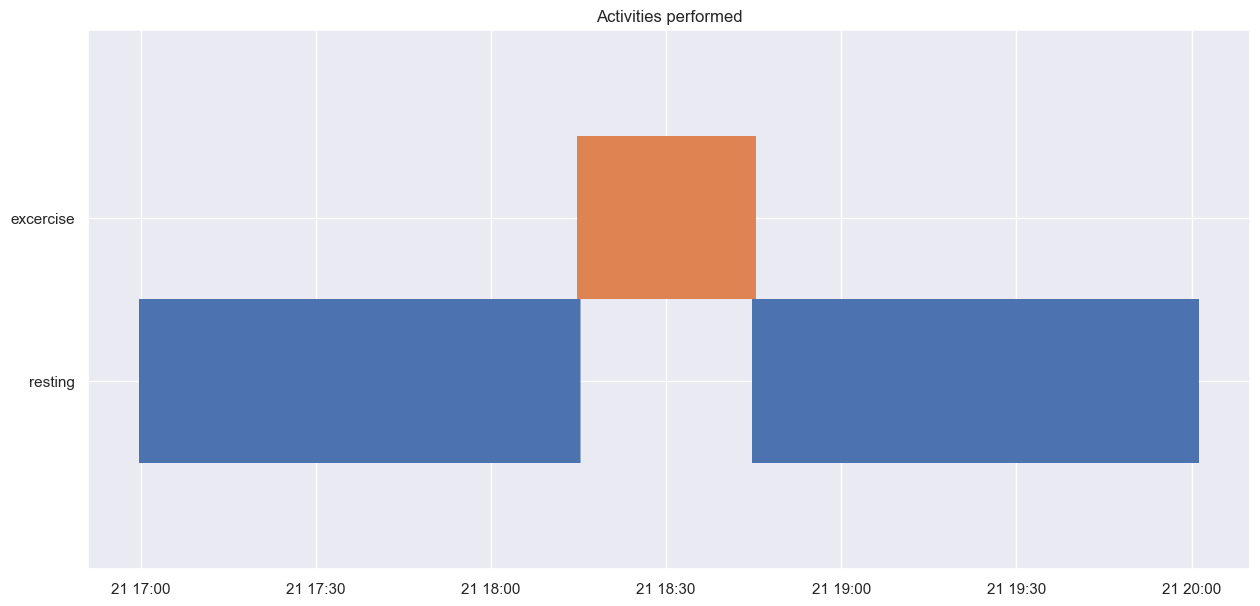

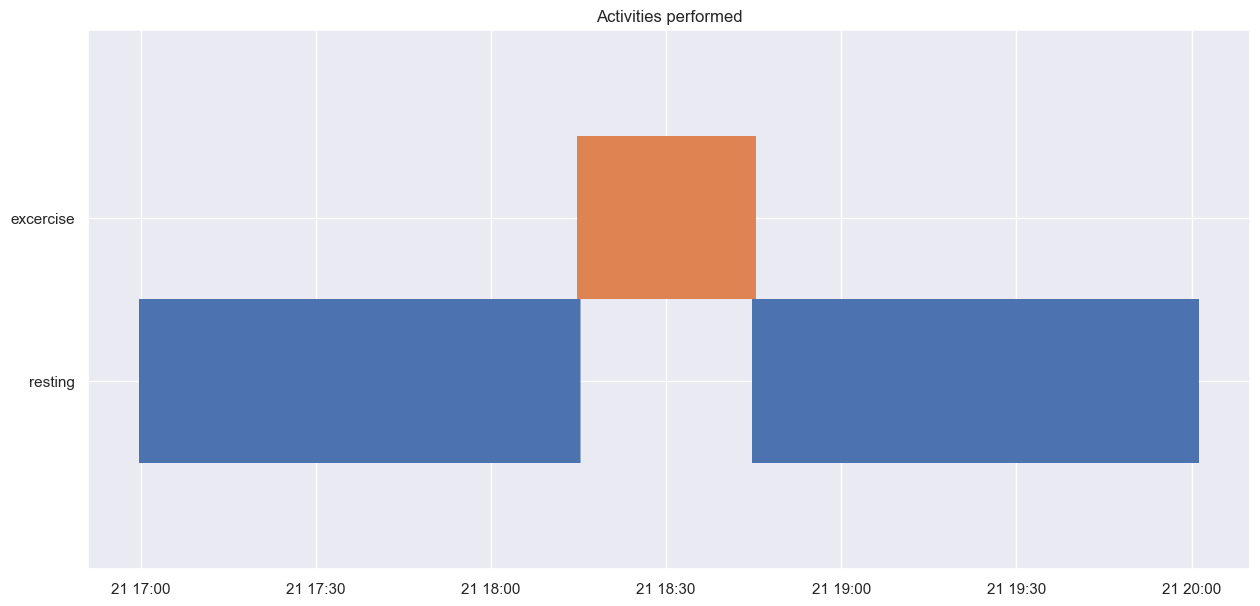

In [60]:
def activit_plot(pd_ds):
    labels = list()
    for i in range(1,3):
        labels.append(np.where(pd_ds.phys==i)[0])
    labels = [pd_ds.index[c] for c in labels]
    colors1 = ['C{}'.format(i) for i in range(len(labels))]
    # create a horizontal plot
    fig = plt.figure(figsize=(15,7))
    lineoffsets = [1,2]
    plt.eventplot(labels, colors=colors1, lineoffsets=lineoffsets)
    plt.yticks([1,2], ["resting", "excercise"])
    plt.title("Activities performed")
    return fig

activit_plot(sensor_ds['00_506_1'][start_time:end_time])

In [51]:
for pat in sensor_ds:
    sensor_ds[pat] = sensor_ds[pat].drop('phys',axis=1)

In [45]:
sensor_ds['00_506_2'].phys[0]

1